In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from fastai import *
from fastai.vision import *
import numpy as np


#processing tokens

import unicodedata 
import re
import inflect 

#tokenize
from nltk import word_tokenize, sent_tokenize

#find ngrams
from nltk.util import ngrams

import time
from tqdm import tqdm

#nn
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

import arpa

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


GeForce GTX 1060 6GB
True


# load inputs from pickle file

### prefix count
### ngram count
### n-1gram count 
### unigram count
### pre-pre fix count

In [3]:
#inputs = torch.load('../../pickles/50-50_5input_4793918').transpose(-2,1).float()
#outputs = torch.load('../../pickles/50-50_output_4793918').flatten().float()
inputs = torch.load('../../pickles/50-50_5input_4793918').transpose(-2,1).float()
outputs = torch.load('../../pickles/50-50_output_4793918').flatten().float()

print(inputs)
print(outputs)
inputs = 1/inputs

tensor([[7.0000e+00, 2.0000e+00, 3.3570e+03, 1.2480e+05, 4.9700e+02],
        [6.0000e+00, 2.0000e+00, 5.4990e+03, 1.6983e+06, 4.9700e+02],
        [3.0000e+00, 3.0000e+00, 8.7100e+02, 4.6025e+04, 4.9700e+02],
        ...,
        [4.0000e+00, 3.0000e+00, 1.5363e+04, 3.0418e+06, 1.0950e+03],
        [5.0000e+00, 3.0000e+00, 3.2000e+01, 2.2400e+04, 1.8000e+01],
        [5.0000e+00, 2.0000e+00, 2.0000e+00, 1.4920e+03, 5.0000e+00]],
       device='cuda:0')
tensor([1.0000, 0.1667, 1.0000,  ..., 0.6000, 1.0000, 0.1429], device='cuda:0')


In [4]:
if device.type == 'cuda':
    #print(torch.cuda.get_device_name(0))
    print('\nMemory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')


Memory Usage:
Allocated: 110.3 MB
Cached:    298.0 MB


# Neural Net


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 5)
        self.fc2 = nn.Linear(5, 4)
        self.fc3 = nn.Linear(4, 1)

        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x)) 
        return x

# Training

In [19]:
net = Net().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)

criterion = torch.nn.L1Loss()  #mean absolute error
#criterion = torch.nn.MSELoss()  #mean square error

In [20]:
## run the model for 3 epochs
#for epoch in range(0,3):
for x in tqdm(range(len(inputs)),position=0, leave=True):
    if x % 10 == 1:
        optimizer.zero_grad() #reset gradients

        ## 1. forward propagation
        net_out = net((inputs[x:x+1,:]))

        ## 2. loss calculation
        loss = criterion(net_out, outputs[x].reshape(1,1))
        #print(target[x])

        ## 3. backward propagation
        loss.backward()

        ## 4. weight optimization
        optimizer.step()

100%|██████████| 4793918/4793918 [10:47<00:00, 7399.68it/s]


# Saving Model

In [9]:
torch.save(net.state_dict(), 'NN saves/temp')

# Loading model

In [6]:
net = Net().cuda()
net.load_state_dict(torch.load('NN saves/50-50_5inputs'))
net.eval()

Net(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)

# Comparing: 
## done on dev set - tbd

In [9]:
x = 1
print(net(inputs[x:x+1,:]))
print(inputs[x:x+1,0:4])

tensor([[0.1976]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.6667e-01, 5.0000e-01, 1.8185e-04, 5.8883e-07]], device='cuda:0')


In [21]:

#difference = np.zeros(int(len(inputs)/10)+1)
net_results = np.zeros(int(len(inputs)/10)+1)
actual_results = np.zeros(int(len(inputs)/10)+1)

'''
#difference =np.zeros(len(inputs))
net_results = np.zeros(len(inputs))
actual_results = np.zeros(len(inputs))
'''
count = 0

for x in tqdm(range(len(inputs)),position=0, leave=True):
    if x%10 == 1:
        net_results[count] = net(inputs[x:x+1,:])
        #ins = torch.tensor([[inputs[x:x+1,0]/inputs[x:x+1,1],inputs[x:x+1,2],inputs[x:x+1,3]]], device = device)
        #net_results[count] = net(ins)
        actual_results[count] = outputs[x]
        #ifference[count] = abs(net_results[count] - actual_results[count])
        count += 1

net_results.sort()
actual_results.sort()
#difference.sort()

100%|██████████| 4793918/4793918 [01:53<00:00, 42134.93it/s]


# lr=0.03 m=0.9 MAE

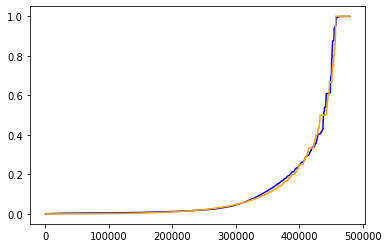

In [22]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [23]:
print(net_results)
print(actual_results)

[2.159838e-04 2.160015e-04 2.160015e-04 2.161031e-04 ... 9.990897e-01 9.990897e-01 9.991054e-01 9.991054e-01]
[2.60748e-06 2.60748e-06 2.60748e-06 2.60748e-06 ... 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]


# lr=0.1 m=0.9 MAE

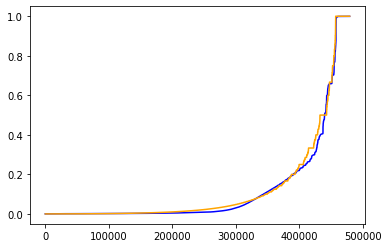

In [17]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [18]:
print(net_results)
print(actual_results)

[2.886989e-04 2.887066e-04 2.887066e-04 2.887507e-04 ... 9.993784e-01 9.993784e-01 9.993786e-01 9.993786e-01]
[2.60748e-06 2.60748e-06 2.60748e-06 2.60748e-06 ... 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]


# lr=0.01 m=0.9 MAE

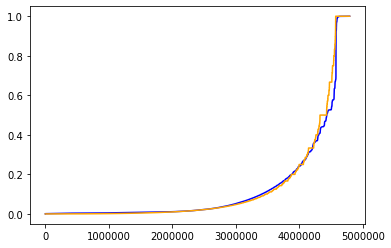

In [16]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [27]:
print(net_results)
print(actual_results)

[4.443272e-04 4.443272e-04 4.443340e-04 4.443340e-04 ... 9.999745e-01 9.999745e-01 9.999745e-01 9.999745e-01]
[2.60748e-06 2.60748e-06 2.60748e-06 2.60748e-06 ... 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]


# Visualising $P_{MLE}$ vs $P_{LM}$ vs $P_{NN}$


In [14]:
#difference = np.zeros(int(len(inputs)/10)+1)
#MLE = np.zeros(int(len(inputs)/10)+1)
#PLM = np.zeros(int(len(inputs)/10)+1)
count = 0

#difference = np.zeros(len(inputs))
MLE = np.zeros(len(inputs))
PLM = np.zeros(len(inputs))
for x in tqdm(range(len(inputs)),position=0, leave=True):
    #if x%10 == 1:
    MLE[count] = inputs[x,0]/inputs[x,1]
    PLM[count] = outputs[x]
    #difference[count] = abs(MLE[count] - PLM[count])
    count += 1

MLE.sort()
PLM.sort()
#difference.sort()
#print(MLE)
#print(PLM)

100%|██████████| 4793918/4793918 [04:40<00:00, 17090.44it/s]


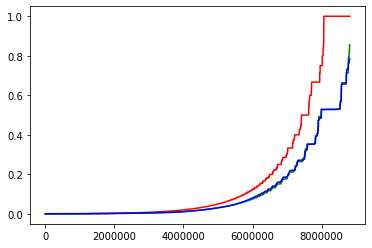

In [25]:
plt.plot(MLE , 'r')
plt.plot(PLM, 'g')
plt.plot(net_results, 'b')
#plt.plot(scaled_results, 'blue')
plt.show()

In [ ]:
# MAE

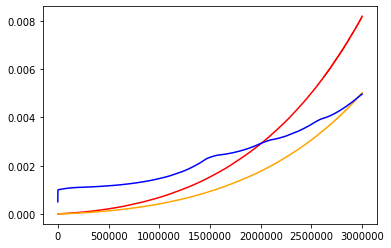

In [28]:
plt.plot(MLE[:3000000] , 'r')
plt.plot(PLM[:3000000], 'orange')
plt.plot(net_results[:3000000], 'b')
#plt.plot(scaled_results[:500000], 'blue')

plt.show()

In [ ]:
# MSE

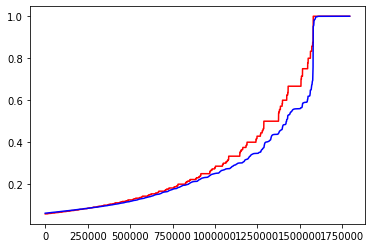

In [15]:
plt.plot(MLE[3000000:5000000] , 'r')
#plt.plot(PLM[:3000000], 'orange')
plt.plot(net_results[3000000:5000000], 'b')
#plt.plot(scaled_results[:500000], 'blue')

plt.show()

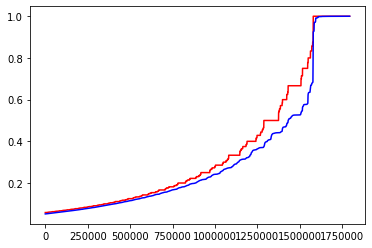

In [22]:
plt.plot(MLE[3000000:5000000] , 'r')
#plt.plot(PLM[:3000000], 'orange')
plt.plot(net_results[3000000:5000000], 'b')
#plt.plot(scaled_results[:500000], 'blue')

plt.show()

In [46]:
print(PLM[0])
print(scaled_results[0])

1.469640096729563e-06
1.469640096729563e-06
